In [13]:
import os 
import glob
from pathlib import Path
import tensorflow as tf
import tensorflow_hub as hub
# For saving 'feature vectors' into a txt file
import numpy as np
# Glob for reading file names in a folder
import glob
import os.path
from tqdm import tqdm
import ntpath
import warnings
import cv2
from annoy import AnnoyIndex
from scipy import spatial
warnings.filterwarnings('ignore')
from operator import itemgetter

In [ ]:
directory = "/home/shreya/img"
my_list = os.listdir(directory)
image_paths = glob.glob(directory + "/*/*/*/*.jpg")
print(image_paths)

In [4]:
def getListOfFiles(dirName):
# create a list of file and sub directories
# names in the given directory
    listOfFile = os.listdir(dirName)
    allFiles = []
#print(len(listOfFile))
# Iterate over all the entries
    temp = glob.glob(str(Path(dirName)) + "/*.jpg")
    allFiles.extend(temp)
    for entry in listOfFile:
# Create full path
        fullPath = os.path.join(dirName, entry)
        fullPath = Path(fullPath)
#print(fullPath)
# If entry is a directory then get the list of files in this directory
        if os.path.isdir(fullPath):
            print(fullPath)
            allFiles.extend(getListOfFiles(fullPath))
    return allFiles

In [5]:
allFiles = getListOfFiles(directory)

/Users/harooniqbal/Downloads/test/img/TOPS
/Users/harooniqbal/Downloads/test/img/TOPS/Summer_Wear
/Users/harooniqbal/Downloads/test/img/TOPS/Summer_Wear/id_00007169
/Users/harooniqbal/Downloads/test/img/TOPS/Summer_Wear/id_00032880
/Users/harooniqbal/Downloads/test/img/TOPS/Summer_Wear/id_00002629
/Users/harooniqbal/Downloads/test/img/TOPS/Summer_Wear/id_00020579
/Users/harooniqbal/Downloads/test/img/TOPS/Summer_Wear/id_00006289
/Users/harooniqbal/Downloads/test/img/TOPS/Summer_Wear/id_00016827
/Users/harooniqbal/Downloads/test/img/TOPS/Summer_Wear/id_00031639
/Users/harooniqbal/Downloads/test/img/TOPS/Summer_Wear/id_00020921
/Users/harooniqbal/Downloads/test/img/TOPS/Summer_Wear/id_00019437
/Users/harooniqbal/Downloads/test/img/TOPS/Summer_Wear/id_00005068
/Users/harooniqbal/Downloads/test/img/TOPS/Summer_Wear/id_00005854
/Users/harooniqbal/Downloads/test/img/TOPS/Summer_Wear/id_00004986
/Users/harooniqbal/Downloads/test/img/TOPS/Summer_Wear/id_00022478
/Users/harooniqbal/Downloads/te

In [6]:
import shutil
adict = {}
fin = []
target = Path("/Users/harooniqbal/Downloads/test/final_img")
print(len(allFiles))
for i in range(1500):
    os.rename(allFiles[i], (str(target)+"/"+str(i)+".jpg"))
    adict[str(i)] = str(os.path.basename(os.path.dirname(Path(allFiles[i]))))

239557


In [7]:
adict

{'0': 'id_00007169',
 '1': 'id_00007169',
 '2': 'id_00007169',
 '3': 'id_00007169',
 '4': 'id_00032880',
 '5': 'id_00032880',
 '6': 'id_00032880',
 '7': 'id_00002629',
 '8': 'id_00002629',
 '9': 'id_00002629',
 '10': 'id_00002629',
 '11': 'id_00020579',
 '12': 'id_00020579',
 '13': 'id_00006289',
 '14': 'id_00006289',
 '15': 'id_00016827',
 '16': 'id_00016827',
 '17': 'id_00031639',
 '18': 'id_00031639',
 '19': 'id_00031639',
 '20': 'id_00020921',
 '21': 'id_00020921',
 '22': 'id_00019437',
 '23': 'id_00019437',
 '24': 'id_00019437',
 '25': 'id_00019437',
 '26': 'id_00019437',
 '27': 'id_00019437',
 '28': 'id_00019437',
 '29': 'id_00019437',
 '30': 'id_00005068',
 '31': 'id_00005068',
 '32': 'id_00005854',
 '33': 'id_00005854',
 '34': 'id_00005854',
 '35': 'id_00005854',
 '36': 'id_00005854',
 '37': 'id_00005854',
 '38': 'id_00005854',
 '39': 'id_00004986',
 '40': 'id_00004986',
 '41': 'id_00004986',
 '42': 'id_00004986',
 '43': 'id_00022478',
 '44': 'id_00022478',
 '45': 'id_00022478'

In [8]:
def load_img(path):
    # Reads the image file and returns data type of string
    img = tf.io.read_file(path)
    # Decodes the image to W x H x 3 shape tensor with type of uint8
    img = tf.io.decode_jpeg(img, channels=3)
    # Resizes the image to 224 x 224 x 3 shape tensor
    img = tf.image.resize_with_pad(img, 224, 224)
    # Converts the data type of uint8 to float32 by adding a new axis
    # img becomes 1 x 224 x 224 x 3 tensor with data type of float32
    # This is required for the mobilenet model we are using
    img = tf.image.convert_image_dtype(img,tf.float32)[tf.newaxis, ...]

    return img

In [9]:
image_paths= glob.glob('/Users/harooniqbal/Downloads/test/final_img/*.jpg')
print(len(image_paths))
image_paths = image_paths[:1500]
print(len(image_paths))

1500
1500


In [10]:
def get_image_feature_vectors(path):
    module_handle = "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4"
    # Loads the module
    module = hub.load(module_handle)
    # Loops through all images in a local folder

    #print(path)
    # Loads and pre-process the image
    img = load_img(path)
    # Calculate the image feature vector of the img
    features = module(img)
    # Remove single-dimensional entries from the 'features' array  
    feature_set = np.squeeze(features)

    # Saves the image feature vectors into a file for later use
    outfile_name = os.path.basename(filename) + ".npz"

    out_path = os.path.join('/Users/harooniqbal/Downloads/test/final_img/',outfile_name)
    # Saves the 'feature_set' to a text file
    np.savetxt(out_path, feature_set, delimiter=',')

In [11]:
def get_features(img, image_path): 
     # Definition of module with using tfhub.dev
    module_handle = "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4"
    # Loads the module
    module = hub.load(module_handle)
    features = module(img)
    # Remove single-dimensional entries from the 'features' array  
    feature_set = np.squeeze(features)
    #print(image_path)

    # Saves the image feature vectors into a file for later use
    outfile_name = os.path.basename(image_path) + ".npz"

    out_path = os.path.join('/Users/harooniqbal/Downloads/test/final_img/',outfile_name)
    # Saves the 'feature_set' to a text file
    np.savetxt(out_path, feature_set, delimiter=',')
    vector = np.loadtxt(out_path)
    return vector

In [14]:
#image_paths= glob.glob('/Users/rishabshekar/Downloads/Dataset/*.jpeg')
vectorfiles = glob.glob('/Users/harooniqbal/Downloads/test/final_img/*.npz')
# compute styles
image_style_embeddings = {}

for image_path in tqdm(image_paths): 
    image_tensor = load_img(image_path)
    vector = get_features(image_tensor, image_path)
    image_style_embeddings[ntpath.basename(image_path)] = vector

100%|██████████| 1500/1500 [1:01:11<00:00,  2.45s/it]


In [26]:
import json
def cluster():
    print("-------Annoy Index Generation----------------")
    # Defining data structures as empty dict
    file_index_to_file_name = {}
    file_index_to_file_vector = {}
    file_index_to_product_id = {}
    # Configuring annoy parameters
    dims = 1792
    n_nearest_neighbors = 20
    trees = 10000
    # Reads all file names which stores feature vectors
    allfiles = glob.glob('/Users/harooniqbal/Downloads/test/final_img/*.npz')

    t = AnnoyIndex(dims, metric='angular')
    
    for file_index, i in enumerate(allfiles):
    # Reads feature vectors and assigns them into the file_vector 
        file_vector = np.loadtxt(i)

        # Assigns file_name, feature_vectors and corresponding product_id
        file_name = os.path.basename(i).split('.')[0]
        file_index_to_file_name[file_index] = file_name
        file_index_to_file_vector[file_index] = file_vector
        file_index_to_product_id[file_index] = adict[file_name]

        # Adds image feature vectors into annoy index   
        t.add_item(file_index, file_vector)

        print("---------------------------------")
        print("Annoy index     : %s" %file_index)
        print("Image file name : %s" %file_name)
        print("Product id      : %s" %file_index_to_product_id[file_index])
        #print("--- %.2f minutes passed ---------" % ((time.time() - start_time)/60))


    # Builds annoy index
    t.build(trees)

    print ("Step.1 - ANNOY index generation - Finished")
    print ("Step.2 - Similarity score calculation - Started ") 
  
    global named_nearest_neighbors
    named_nearest_neighbors = []

  # Loops through all indexed items
    for i in file_index_to_file_name.keys():

    # Assigns master file_name, image feature vectors and product id values
        master_file_name = file_index_to_file_name[i]
        master_vector = file_index_to_file_vector[i]
        master_product_id = file_index_to_product_id[i]

        # Calculates the nearest neighbors of the master item
        nearest_neighbors = t.get_nns_by_item(i, n_nearest_neighbors)

        # Loops through the nearest neighbors of the master item
        for j in nearest_neighbors:

            # Assigns file_name, image feature vectors and product id values of the similar item
            neighbor_file_name = file_index_to_file_name[j]
            neighbor_file_vector = file_index_to_file_vector[j]
            neighbor_product_id = file_index_to_product_id[j]

            # Calculates the similarity score of the similar item
            similarity = 1 - spatial.distance.cosine(master_vector, neighbor_file_vector)
            rounded_similarity = int((similarity * 10000)) / 10000.0

            # Appends master product id with the similarity score 
            # and the product id of the similar items
            named_nearest_neighbors.append({
            'similarity': rounded_similarity,
            'master_pi': master_product_id,
            'similar_pi': neighbor_product_id})
#     print(named_nearest_neighbors)
#     print(type(named_nearest_neighbors))
    with open('nearest_neighbors_final.json', 'w') as out:
        json.dump(named_nearest_neighbors, out)      
#     return named_nearest_neighbors

In [27]:
#image_paths = glob.glob('/Users/rishabshekar/Downloads/Dataset/*.jpeg')
print(f'Founnd [{len(image_paths)}] images')

images = []
for image_path in image_paths:
    image = cv2.imread(image_path, 3)
    b,g,r = cv2.split(image)           # get b, g, r
    image = cv2.merge([r,g,b])         # switch it to r, g, b
    image = cv2.resize(image, (200, 200))
    product_id = adict[(ntpath.basename(image_path).split(".")[0])]
    images.append({
      'image_path' : ntpath.basename(image_path),
        'image' : image,
       'product_id':product_id
    })
#     images['image_path'] = ntpath.basename(image_path)
#     images['image'] = image
#     #images[ntpath.basename(image_path)] = image
#     product_id = match_id(ntpath.basename(image_path))
#     images['product_id'] = product_id

Founnd [1500] images


In [28]:
cluster()

-------Annoy Index Generation----------------
---------------------------------
Annoy index     : 0
Image file name : 86
Product id      : id_00018511
---------------------------------
Annoy index     : 1
Image file name : 457
Product id      : id_00021652
---------------------------------
Annoy index     : 2
Image file name : 1187
Product id      : id_00032084
---------------------------------
Annoy index     : 3
Image file name : 96
Product id      : id_00029256
---------------------------------
Annoy index     : 4
Image file name : 447
Product id      : id_00003730
---------------------------------
Annoy index     : 5
Image file name : 1197
Product id      : id_00033156
---------------------------------
Annoy index     : 6
Image file name : 202
Product id      : id_00006873
---------------------------------
Annoy index     : 7
Image file name : 212
Product id      : id_00018175
---------------------------------
Annoy index     : 8
Image file name : 985
Product id      : id_00017337


In [29]:
from scipy import spatial
import matplotlib.pyplot as plt
def search_similar_image(reference_image, max_results):
    reference_image = adict[reference_image]
    print(reference_image)
    nearest = []
    #print(named_nearest_neighbors[1]['master_pi'])
    #f, ax = plt.subplots(1, max_results, figsize=(16, 8))
    for i in range (0, len(named_nearest_neighbors)):
        if(named_nearest_neighbors[i]['master_pi'] == reference_image):
            nearest.append({
                'similarity' : named_nearest_neighbors[i]['similarity'],
                'master_pi' : named_nearest_neighbors[i]['master_pi'],
                'similar_pi' : named_nearest_neighbors[i]['similar_pi']
            })
    f, ax = plt.subplots(1, max_results, figsize=(16, 8))
    for i in range(0, max_results):
        for j in range(0, len(images)):
            if(nearest[i]['similar_pi'] == images[j]['product_id']):
                ax[i].imshow(images[j]['image'])
                ax[i].set_axis_off()
                
    plt.show()

id_00002629


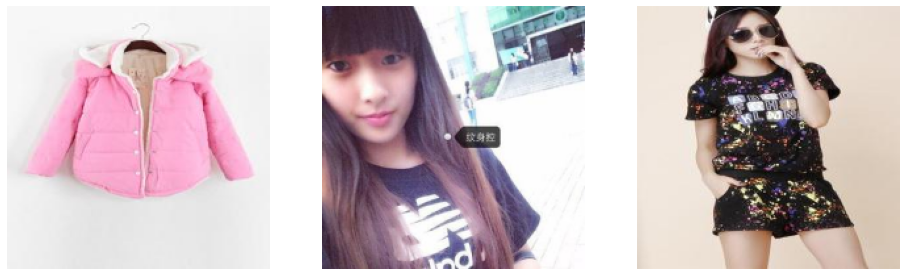

In [40]:
search_similar_image('8', 3)